In [7]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from autogluon.tabular import TabularPredictor


## Define constans and functions

In [8]:
locations = ["A", "B", "C"]
features_order = []

LAGGED_COLUMNS_TO_KEEP = [
    'direct_rad:W_lag_1h', 
    'direct_rad:W_lag_forward_1h', 
    'clear_sky_rad:W_lag_1h', 
    'clear_sky_rad:W_lag_forward_1h', 
    'diffuse_rad:W_lag_1h', 
    'diffuse_rad:W_lag_forward_1h', 
    'direct_rad_1h:J_lag_1h', 
    'direct_rad_1h:J_lag_forward_1h', 
    'is_in_shadow:idx_lag_1h', 
    'is_in_shadow:idx_lag_forward_1h', 
    'clear_sky_energy_1h:J_lag_1h', 
    'clear_sky_energy_1h:J_lag_forward_1h', 
    'effective_cloud_cover:p_lag_1h', 
    'effective_cloud_cover:p_lag_forward_1h', 
    'visibility:m_lag_1h', 
    'visibility:m_lag_forward_1h', 
    'total_cloud_cover:p_lag_1h', 
    'total_cloud_cover:p_lag_forward_1h', 


    # 'direct_rad:W_lag_2h', 
    # 'direct_rad:W_lag_forward_2h', 
    # 'clear_sky_rad:W_lag_2h', 
    # 'clear_sky_rad:W_lag_forward_2h', 
    # 'diffuse_rad:W_lag_2h', 
    # 'diffuse_rad:W_lag_forward_2h', 
    # 'direct_rad_1h:J_lag_2h', 
    # 'direct_rad_1h:J_lag_forward_2h', 
    # 'is_in_shadow:idx_lag_2h', 
    # 'is_in_shadow:idx_lag_forward_2h', 
    # 'clear_sky_energy_1h:J_lag_2h', 
    # 'clear_sky_energy_1h:J_lag_forward_2h', 
    # 'effective_cloud_cover:p_lag_2h', 
    # 'effective_cloud_cover:p_lag_forward_2h', 
    # 'visibility:m_lag_2h', 
    # 'visibility:m_lag_forward_2h', 
    # 'total_cloud_cover:p_lag_2h', 
    # 'total_cloud_cover:p_lag_forward_2h', 

    # 'direct_rad:W_lag_3h', 
    # 'direct_rad:W_lag_forward_3h', 
    # 'clear_sky_rad:W_lag_3h', 
    # 'clear_sky_rad:W_lag_forward_3h', 
    # 'diffuse_rad:W_lag_3h', 
    # 'diffuse_rad:W_lag_forward_3h', 
    # 'direct_rad_1h:J_lag_3h', 
    # 'direct_rad_1h:J_lag_forward_3h', 
    # 'is_in_shadow:idx_lag_3h', 
    # 'is_in_shadow:idx_lag_forward_3h', 
    # 'clear_sky_energy_1h:J_lag_3h', 
    # 'clear_sky_energy_1h:J_lag_forward_3h', 
    # 'effective_cloud_cover:p_lag_3h', 
    # 'effective_cloud_cover:p_lag_forward_3h', 
    # 'visibility:m_lag_3h', 
    # 'visibility:m_lag_forward_3h', 
    # 'total_cloud_cover:p_lag_3h', 
    # 'total_cloud_cover:p_lag_forward_3h'
]

CUSTOM_COLUMNS_TO_KEEP = [
    "hour_cos",
    "hour_sin",
    "month_sin",
    "month_cos",
    "day-of-year",
]

WEATHER_FEATURES = [
    "direct_rad:W",
    "clear_sky_rad:W",
    "diffuse_rad:W",
    "direct_rad_1h:J",
    "is_in_shadow:idx",
    "clear_sky_energy_1h:J",
    "effective_cloud_cover:p",
    "visibility:m",
    "total_cloud_cover:p",
]


TEST_COLUMNS_TO_KEEP = [
    "direct_rad:W",
    "clear_sky_rad:W",
    "diffuse_rad:W",
    "direct_rad_1h:J",
    "is_in_shadow:idx",
    "clear_sky_energy_1h:J",
    "diffuse_rad_1h:J",
    "is_day:idx",
    "sun_elevation:d",
    "ceiling_height_agl:m",
    "effective_cloud_cover:p",
    "visibility:m",
    "total_cloud_cover:p",
    "air_density_2m:kgm3",
    "wind_speed_v_10m:ms",
    "dew_point_2m:K",
    "wind_speed_u_10m:ms",
    "t_1000hPa:K",
    "absolute_humidity_2m:gm3",
    "snow_water:kgm2",
    "relative_humidity_1000hPa:p",
    "fresh_snow_24h:cm",
    "cloud_base_agl:m",
    "fresh_snow_12h:cm",
    "snow_depth:cm",
    "dew_or_rime:idx",
    "fresh_snow_6h:cm",
    "super_cooled_liquid_water:kgm2",
    "fresh_snow_3h:cm",
    "rain_water:kgm2",
    "precip_type_5min:idx",
    "precip_5min:mm",
    "fresh_snow_1h:cm",
    "sun_azimuth:d",
    "msl_pressure:hPa",
    "pressure_100m:hPa",
    "pressure_50m:hPa",
    "sfc_pressure:hPa",
    "prob_rime:p",
    "wind_speed_10m:ms",
    "elevation:m",
    # "snow_density:kgm3",
    "snow_drift:idx",
    "snow_melt_10min:mm",
    "wind_speed_w_1000hPa:ms",
    "observed_or_estimated"
    # "location_A",
    # "location_B",
    # "location_C",
    # "date_calc",
] + CUSTOM_COLUMNS_TO_KEEP  +  LAGGED_COLUMNS_TO_KEEP

COLUMNS_TO_KEEP = TEST_COLUMNS_TO_KEEP + ["pv_measurement"]



def create_weather_lagged_features(df, weather_features):
    # Choose the weather features for which you want to create lagged versions
    for feature in weather_features:
        # Assuming hourly data, adjust the lags for your specific dataset
        # Creating lagged features for 1 hour, 1 day, and 1 week
        df[f'{feature}_lag_1h'] = df[feature].shift(1)
        # df[f'{feature}_lag_2h'] = df[feature].shift(2)
        # df[f'{feature}_lag_3h'] = df[feature].shift(3)

        df[f'{feature}_lag_forward_1h'] = df[feature].shift(-1)
        # df[f'{feature}_lag_forward_2h'] = df[feature].shift(-2)
        # df[f'{feature}_lag_forward_3h'] = df[feature].shift(-3)
        # df[f'{feature}_lag_24h'] = df[feature].shift(24*4)
        # df[f'{feature}_lag_168h'] = df[feature].shift(24 * 7 * 4 * 365)
        # df[f'{feature}_front_lag_1h'] = df[feature].shift(-4)
        # df[f'{feature}_front_lag_24h'] = df[feature].shift(-24*4)


    # Handling edges by filling NaNs with appropriate values or dropping them
    # You may choose to fill with zeroes or interpolate, based on what makes more sense for your data
    df.fillna(method='ffill', inplace=True)  # Forward fill
    df.fillna(method='bfill', inplace=True)  # Backward fill
    
    return df


def create_lagged_features(df, column_name='pv_measurement'):
    # Assuming 'date_forecast' is the datetime column used for sorting

    df[f'{column_name}_prev_month'] = df[column_name].shift(24*7) # previous week

    # For yearly lag, you would need to calculate the number of observations per year
    # If the data is not consistent (leap years, etc.), you may need a more complex method
    # Here's a simple version assuming 365 days a year:
    df[f'{column_name}_prev_year'] = df[column_name].shift(24*365) # previous year
    df[f'{column_name}_2years_ago'] = df[column_name].shift(24*365*2) # next year

    # Handling edges by filling NaNs with appropriate values or dropping them
    df.fillna(method='ffill', inplace=True)  # Forward fill
    df.fillna(method='bfill', inplace=True)  # Backward fill

    return df


## Prepare data


In [9]:
def add_custom_fields(df):
     df['hour_sin'] = np.sin(2 * np.pi * df['date_forecast'].dt.hour / 24)
     df['hour_cos'] = np.cos(2 * np.pi * df['date_forecast'].dt.hour / 24)

     df['month_sin'] = np.sin(2 * np.pi * df['date_forecast'].dt.month / 12)
     df['month_cos'] = np.cos(2 * np.pi * df['date_forecast'].dt.month / 12)
     df['day-of-year'] = df['date_forecast'].dt.dayofyear
     return df

def remove_outliers(df):
    # Use a mask to filter out the rows where rolling std is zero but keep the rows where the value itself is zero
    mask = (df['pv_measurement'].rolling(5).std() == 0) & (df['pv_measurement'] != 0)
    df = df[~mask]
    return df

def resample_add_data(df, is_test_data):
    df = add_custom_fields(df)
    df.set_index('date_forecast', inplace=True)
    df = df.resample('1H').mean()
    # Remove empty dates if test data
    if is_test_data:
        non_nan_threshold = len(df.columns) // 2  
        df.dropna(thresh=non_nan_threshold, inplace=True)
    df.interpolate(method="linear", inplace=True)
    
    return df

def add_location_feature(X, location):
      # Treat location as a categorical feature by converting it to a category type
    X['location'] = location
    X['location'] = X['location'].astype(str)  # Convert to string if 'location' is not an int
    X['dew_or_rime:idx'] = X['dew_or_rime:idx'].astype(str)
    X['is_day:idx'] = X['is_day:idx'].astype(str)
    X['is_in_shadow:idx'] = X['is_in_shadow:idx'].astype(str)
    categorical_columns = ['location', 'dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx']

    # Before filling NaN values, add 'missing' as a category for each categorical column.
    for column in categorical_columns:
        X[column] = X[column].astype('category')  # Ensure the column is of type 'category'.
        if 'missing' not in X[column].cat.categories:
            X[column] = X[column].cat.add_categories(['missing'])  # Add 'missing' as a new category.
        X[column] = X[column].fillna('missing')
    X['location'] = X['location'].astype('category')
    X['dew_or_rime:idx'] = X['dew_or_rime:idx'].astype('category')
    X['is_day:idx'] = X['is_day:idx'].astype('category')
    X['is_in_shadow:idx'] = X['is_in_shadow:idx'].astype('category')
    
    return X

def add_scaling(X_test, X_training, location):
    global scalers
    continuous_columns = X_training.select_dtypes(include=['float32', 'int32']).columns
    if location not in scalers:
        scalers[location] = MinMaxScaler()
    X_training[continuous_columns] = scalers[location].fit_transform(X_training[continuous_columns])
    
    X_test[continuous_columns] = scalers[location].transform(X_test[continuous_columns])

    return X_test, X_training

def make_observed_and_estimated_category(df_observed, df_estimated, df_test):
     # Hot encode in wether observed or estimated
    df_observed['observed_or_estimated'] = 'observed'
    df_estimated['observed_or_estimated'] = 'estimated'
    df_test['observed_or_estimated'] = 'estimated'
    # Concatenate observed and estimated
    df_training = pd.concat([df_observed, df_estimated], axis=0).sort_values(by="date_forecast")
    df_training['observed_or_estimated'] = df_training['observed_or_estimated'].astype('category')
    df_test['observed_or_estimated'] = df_test['observed_or_estimated'].astype('category')

    return df_training, df_test

    
    

In [10]:

# Initialize a dictionary to hold the scalers for each location

scalers = {}


def prepare_data(location):
    # Load data
    scaling = False  # Set scaling to True to enable individual scaling for each location
    global scalers

    # Load training data
    df_observed = pd.read_parquet(f"data/{location}/X_train_observed.parquet")
    df_estimated = pd.read_parquet(f"data/{location}/X_train_estimated.parquet")
    df_target = pd.read_parquet(f"data/{location}/train_targets.parquet")

   
    # Load test data
    df_test = pd.read_parquet(f"data/{location}/X_test_estimated.parquet")

   
    # Hot encode in wether observed or estimated

    # Resample and add custom fields

    df_observed = resample_add_data(df_observed, False)
    df_estimated = resample_add_data(df_estimated, False)
    df_test = resample_add_data(df_test, True)

    df_training, df_test = make_observed_and_estimated_category(df_observed, df_estimated, df_test)

    # Merge training with target data
    df_training = pd.merge(df_training, df_target, left_on="date_forecast", right_on="time", how="inner")
    
    # Create lagged features and remove outliers training
    df_training = create_weather_lagged_features(df_training, WEATHER_FEATURES)
    df_training = df_training[COLUMNS_TO_KEEP]
    df_training = remove_outliers(df_training)


    # Add categories
    df_training = add_location_feature(df_training, location)
    X_test = add_location_feature(df_test, location)
    
    # Add scaling
    if scaling:
        X_test, X_training = add_scaling(X_test, X_training, location)
    df_training.reset_index(inplace=True)
    # y_training = np.log1p(y_training)
    return df_training, X_test



# Use prepare_data function

combined_df_train = pd.DataFrame()
combined_df_test = pd.DataFrame()

for location in locations:
    # Prepare the training data
    X_training, X_test = prepare_data(location)
    
    combined_df_train = pd.concat([combined_df_train, X_training])

    combined_df_test = pd.concat([combined_df_test, X_test])

# Set last 720 datapoints of X_training as validation data
X_training, X_validation = train_test_split(combined_df_train, test_size=720, shuffle=False)
print()

/var/folders/fm/6k4602pj3xx1rcp_y10195140000gn/T/ipykernel_92367/3755544180.py:162: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill
/var/folders/fm/6k4602pj3xx1rcp_y10195140000gn/T/ipykernel_92367/3755544180.py:163: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)  # Backward fill
/var/folders/fm/6k4602pj3xx1rcp_y10195140000gn/T/ipykernel_92367/3755544180.py:162: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill
/var/folders/fm/6k4602pj3xx1rcp_y10195140000gn/T/ipykernel_92367/3755544180.py:163: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a f

/var/folders/fm/6k4602pj3xx1rcp_y10195140000gn/T/ipykernel_92367/3755544180.py:162: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill
/var/folders/fm/6k4602pj3xx1rcp_y10195140000gn/T/ipykernel_92367/3755544180.py:163: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)  # Backward fill


## Train

In [11]:
def train_model(dataset):
    # Define the path where the AutoGluon models will be saved
    save_path = f'autogluon_models/simen_model'
    
    # Initialize the TabularPredictor object
    model = TabularPredictor(label='pv_measurement', path=save_path)
    model.fit(train_data=dataset, presets='best_quality', excluded_model_types="LightGBM")    
    return model

def evaluate_model(X_val, y_val, location, model=None):
    if model is None:
        # If no model is passed, we assume the model has been previously saved and needs to be loaded
        save_path = f'autogluon_models_location_{location}'
        model = TabularPredictor.load(save_path)

    # Predictions are made on the non-transformed validation data
    y_pred = model.predict(X_val)
    
    # If y_val was transformed (e.g., log1p), then apply the inverse transformation
    # y_val = np.expm1(y_val)
    # y_pred = np.expm1(y_pred)
    
    # Calculate the MAE
    mae = mean_absolute_error(y_val, y_pred)
    print(f'Location {location}, Mean Absolute Error: {mae}')

# Train the model using all available training data and the initial validation set for early stopping
model = train_model(combined_df_train)

# Evaluate the model using the same validation set
# evaluate_model(combined_X_val, combined_Y_val, location, model)


Presets specified: ['best_quality']
/Users/simenseeberg/Documents/ntnu/h23/tdt4173/project/TDT4173-project/.venv/lib/python3.11/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "autogluon_models/simen_model"
AutoGluon Version:  0.8.3b20231109
Python Version:     3.11.5
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.0.0: Fri Sep 15 14:43:05 PDT 2023; root:xnu-10002.1.13~1/RELEASE_ARM64_T6020
Disk Space Avail:   183.16 GB / 494.38 GB (37.0%)
Train Data Rows:    90065
Train Data Columns: 70
Label Column: pv_measurement
Preprocessing data ...
/Users/simenseebe

## Make predictions

In [12]:

# Assuming you have defined WEATHER_FEATURES, TEST_COLUMNS_TO_KEEP, and other functions previously

def make_predictions(df_test_pred):
    eval_model = TabularPredictor.load("autogluon_models/test_model", require_version_match=False)

    preds = eval_model.predict(df_test_pred)
    
    
    # Inverse transform the predictions
    # preds = np.expm1(preds)
    return preds





## Evaluate locally


/Users/simenseeberg/Documents/ntnu/h23/tdt4173/project/TDT4173-project/.venv/lib/python3.11/site-packages/autogluon/features/generators/fillna.py:58: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X.fillna(self._fillna_feature_map, inplace=True, downcast=False)


(720,)
Number of predictions that are a lower value than the actual, given that the actual is not 0: 441
Number of predictions that are larger than the target, given that the target is not 0: 30


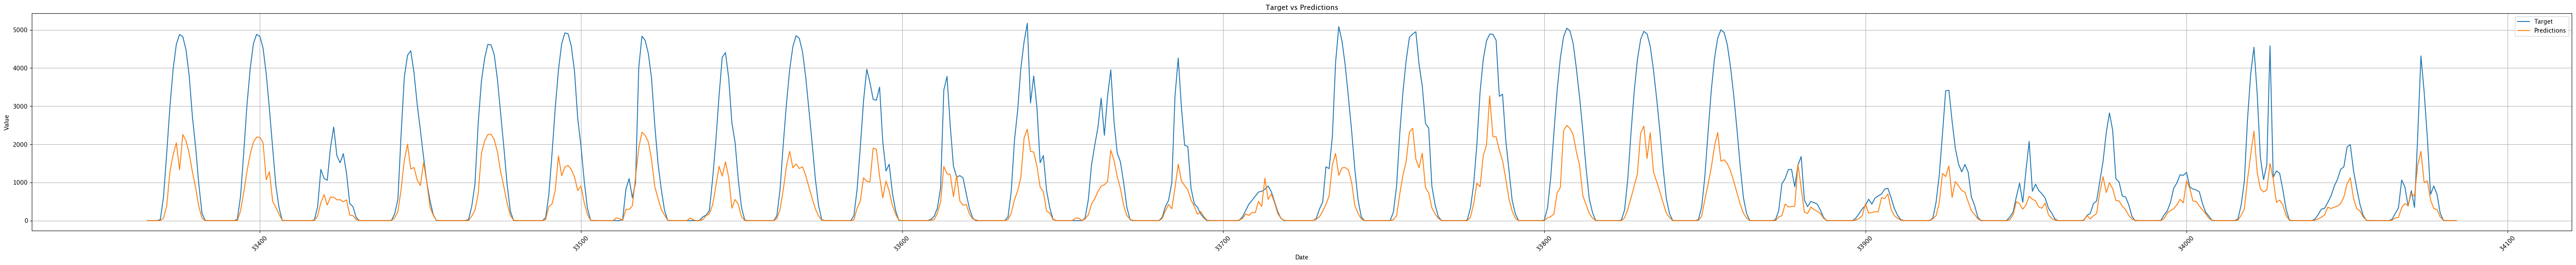

/Users/simenseeberg/Documents/ntnu/h23/tdt4173/project/TDT4173-project/.venv/lib/python3.11/site-packages/autogluon/features/generators/fillna.py:58: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X.fillna(self._fillna_feature_map, inplace=True, downcast=False)


(720,)
Number of predictions that are a lower value than the actual, given that the actual is not 0: 14
Number of predictions that are larger than the target, given that the target is not 0: 447


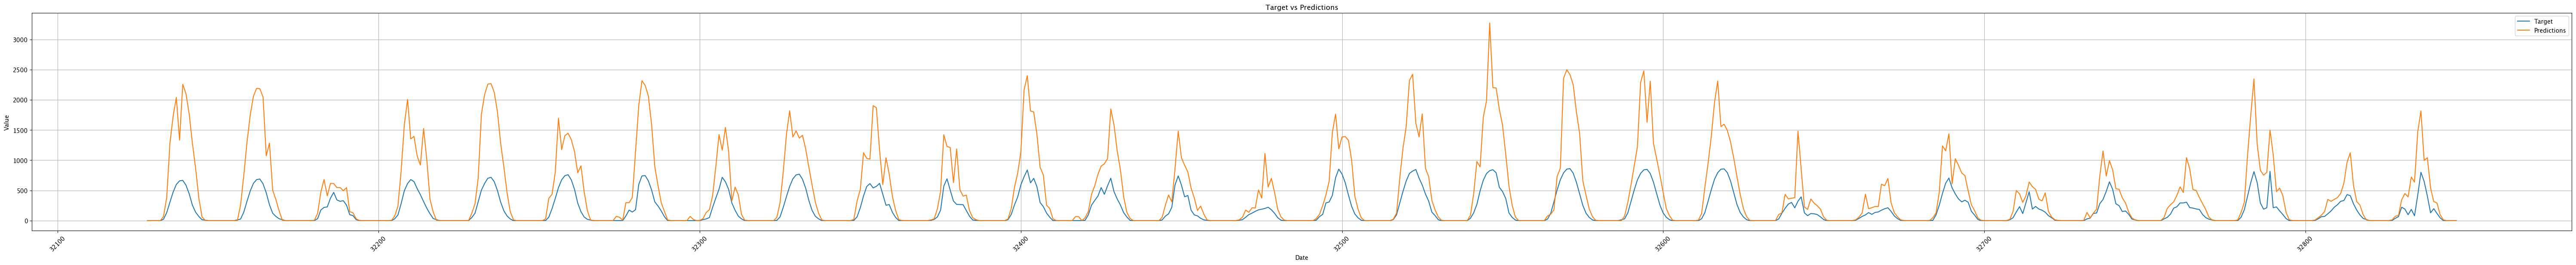

/Users/simenseeberg/Documents/ntnu/h23/tdt4173/project/TDT4173-project/.venv/lib/python3.11/site-packages/autogluon/features/generators/fillna.py:58: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X.fillna(self._fillna_feature_map, inplace=True, downcast=False)


(720,)
Number of predictions that are a lower value than the actual, given that the actual is not 0: 70
Number of predictions that are larger than the target, given that the target is not 0: 385


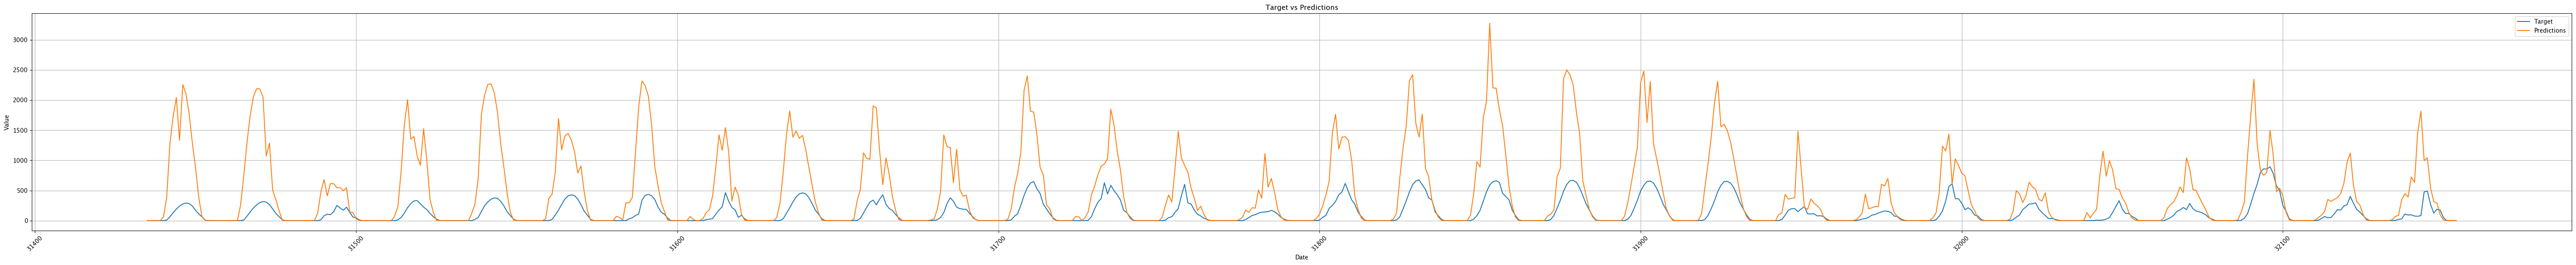

In [13]:
import matplotlib.pyplot as plt


def evaluate_model_locally(location, scalers):
    # Load the test data
    target_df = pd.read_parquet(f"data/{location}/train_targets.parquet")
    
    # Make predictions
    preds = make_predictions(X_validation.drop("pv_measurement", axis=1))[-720:]
    target = target_df.tail(720)["pv_measurement"].to_numpy()
    
    differences = preds - target
    # Count predictions lower than the actual
    lower_predictions = (differences < 0) & (target != 0)
    # Count predictions higher than the actual
    higher_predictions = (differences > 0) & (target != 0)

    print(preds.shape)

    # Biggest misreads
    absolute_differences = abs(differences)
    max_diff_index = absolute_differences.argmax()  # Index of the biggest difference
    # max_diff_value = absolute_differences[max_diff_index]  # Value of the biggest difference
    print(f"Number of predictions that are a lower value than the actual, given that the actual is not 0: {lower_predictions.sum()}")
    print(f"Number of predictions that are larger than the target, given that the target is not 0: {higher_predictions.sum()}")
    # print(f"The biggest misread is at index {max_diff_index} with a difference of {max_diff_value}")
    
    index = target_df.index[-720:]
    # Plotting
    plt.figure(figsize=(60,6))
    plt.plot(index, target, label="Target")
    plt.plot(index, preds, label="Predictions")
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Target vs Predictions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

for loc in locations:
    evaluate_model_locally(loc, scalers)


## Submit to csv 1

In [14]:
df_submission = pd.read_csv("data/test.csv")

preds = make_predictions(combined_df_test)
print(len(preds))
print(len(df_submission))
df_submission["prediction"] = preds

# Save the results to a new submission file
df_submission[["id", "prediction"]].to_csv("kaggle_submission_catboost_10.csv", index=False)

KeyError: "19 required columns are missing from the provided dataset to transform using AutoMLPipelineFeatureGenerator. 19 missing columns: ['index', 'direct_rad:W_lag_1h', 'direct_rad:W_lag_forward_1h', 'clear_sky_rad:W_lag_1h', 'clear_sky_rad:W_lag_forward_1h', 'diffuse_rad:W_lag_1h', 'diffuse_rad:W_lag_forward_1h', 'direct_rad_1h:J_lag_1h', 'direct_rad_1h:J_lag_forward_1h', 'is_in_shadow:idx_lag_1h', 'is_in_shadow:idx_lag_forward_1h', 'clear_sky_energy_1h:J_lag_1h', 'clear_sky_energy_1h:J_lag_forward_1h', 'effective_cloud_cover:p_lag_1h', 'effective_cloud_cover:p_lag_forward_1h', 'visibility:m_lag_1h', 'visibility:m_lag_forward_1h', 'total_cloud_cover:p_lag_1h', 'total_cloud_cover:p_lag_forward_1h'] | 53 available columns: ['date_calc', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day-of-year', 'observed_or_estimated', 'location']"